<a href="https://colab.research.google.com/github/DiegoLLP123/upsrj-keras-workspace/blob/main/RNN_Audio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Red Neuronal Recurrente con audio real

Una red neuronal recurrente nos permite analizar una señal de entrada constante, como puede ser un audio o un video. En este caso vamos a aplicarla sobre un audio dado que las RNN son capaces de aprender timbre, forma de onda, transiciones rápidas, ruido y transitorios.

1. **Subir audio al Colab**

Sube tu propio audio en formato .wav o .mp3

Saving split.wav to split.wav
Archivo subido split.wav
Duración: 10.0 sec.


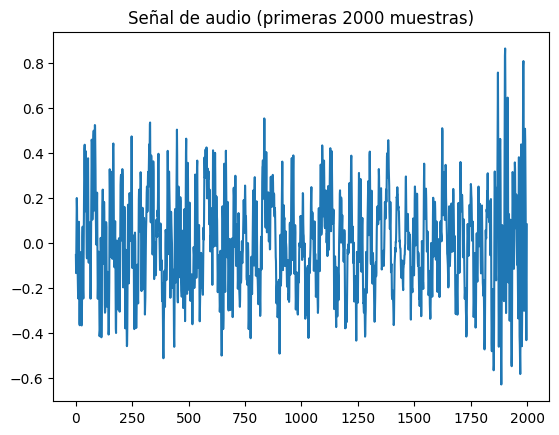

In [12]:
from google.colab import files
import librosa
import numpy as np
import matplotlib.pyplot as plt

# guardamos archivo a subir
uploaded = files.upload()

# obtenemos nombre del archivo
audio_path = list(uploaded.keys())[0]
print("Archivo subido", audio_path)

# cargar audio a 16kHz
signal, sr = librosa.load(audio_path, sr=16000)
signal = signal / np.max(np.abs(signal))
print("Duración:", len(signal)/sr, "sec.")

plt.plot(signal[:2000])
plt.title("Señal de audio (primeras 2000 muestras)")
plt.show()

2. Preparación de las secuencias para la RNN

Tendremos una ventana de 200 muestras (~12.5ms)

In [13]:
# longitud de secuencia: 200 muestras
seq_len = 200
x = []
y = []

# iteramos la señal y generamos arreglos cada 200 muestras
for i in range(len(signal) - seq_len):
 x.append(signal[i:i+seq_len])
 y.append(signal[i+seq_len])

# formateamos a numpy
x = np.array(x)
y = np.array(y)

#reformamos al formato necesario para la RNN (muestras, saltos, características)
x = x.reshape((x.shape[0], seq_len, 1))

print("forma de x", x.shape)
print("forma de y", y.shape)


forma de x (159800, 200, 1)
forma de y (159800,)


3. Construimos una RNN simple en Keras

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense

# Modelo
model = Sequential()

# RNN Layer
model.add(SimpleRNN(64, activation='tanh', input_shape=(seq_len, 1)))

# Output layer
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')
model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_2 (SimpleRNN)        │ (None, 64)             │         4,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,289 (16.75 KB)

 Trainable params: 4,289 (16.75 KB)

 Non-trainable params: 0 (0.00 B)

4. Entrenamos nuestra red con las muestras generadas

In [15]:
history = model.fit(
    x, y,
    epochs=5,
    batch_size=64,
    validation_split=0.1
)

Epoch 1/5
2248/2248 ━━━━━━━━━━━━━━━━━━━━ 31s 13ms/step - loss: 0.0061 - val_loss: 0.0015
Epoch 2/5
2248/2248 ━━━━━━━━━━━━━━━━━━━━ 28s 12ms/step - loss: 0.0024 - val_loss: 0.0013
Epoch 3/5
2248/2248 ━━━━━━━━━━━━━━━━━━━━ 28s 12ms/step - loss: 0.0023 - val_loss: 0.0014
Epoch 4/5
2248/2248 ━━━━━━━━━━━━━━━━━━━━ 28s 12ms/step - loss: 0.0022 - val_loss: 0.0015
Epoch 5/5
2248/2248 ━━━━━━━━━━━━━━━━━━━━ 28s 12ms/step - loss: 0.0025 - val_loss: 0.0012


5. Graficación de pérdida

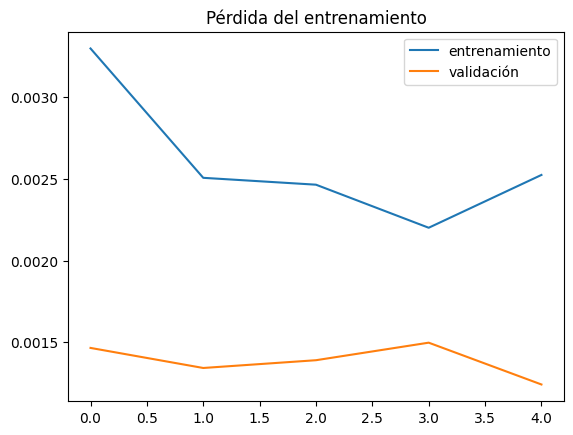

In [16]:
plt.plot(history.history['loss'], label='entrenamiento')
plt.plot(history.history['val_loss'], label='validación')
plt.legend()
plt.title("Pérdida del entrenamiento")
plt.show()

6. Probar la predicción

Comparamos un valor real vs. predicho

In [17]:
# cualquier indice válido
idx = 2000
input_seq = x[idx].reshape(1, seq_len, 1)
pred = model.predict(input_seq)

print("predicción:", pred[0][0])
print("real.", y[idx])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step
predicción: 0.08654788
real. 0.06760063


7. Generar señal de audio con predicción para escucharla

Después de entrenar el modelo, podremos recrear la señal de audio, sin embargo, necesitamos recopilar todas las muestras generadas para unirlas y obtener un dato audible por nosotros.

Generando 32000 muestras (~10 sec)...
Señal de audio generada. forma: (32000,)


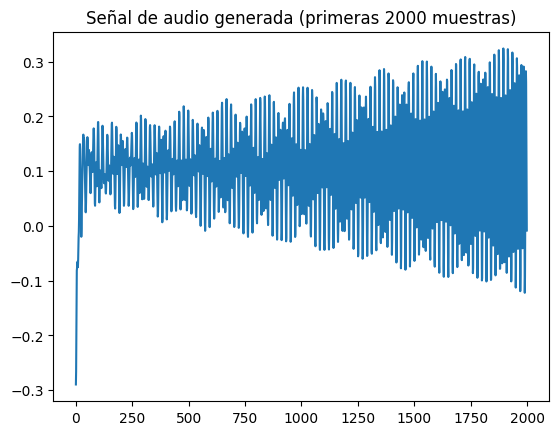

In [18]:
from IPython.display import Audio

# numero de muestras a generar (16kHz * 10s = 160k)
gen_samples = 16000  * 2

# iniciamos con cualquier secuencia del dataset
seed = x[1000].reshape(1, seq_len, 1)

generated = []

current_seq = seed.copy()

print("Generando", gen_samples, "muestras (~10 sec)...")

for i in range(gen_samples):
  # predecimos la siguiente muestra
  next_sample = model.predict(current_seq, verbose=0)[0][0]
  generated.append(next_sample)

  # shifteo: quitamos la primera muestra y agregamos l a nueva
  new_seq = np.append(current_seq[:, 1:, :], [[[next_sample]]], axis = 1)
  current_seq = new_seq

generated = np.array(generated)

print("Señal de audio generada. forma:", generated.shape)
plt.plot(generated[:2000])
plt.title("Señal de audio generada (primeras 2000 muestras)")
plt.show()